In [38]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

from nltk.corpus import stopwords
from nltk.corpus import wordnet 
from nltk.corpus import stopwords
import nltk
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfFile, PdfPages
from ctypes.wintypes import SIZE
from astropy.timeseries import LombScargle
from matplotlib.backends.backend_pdf import PdfFile, PdfPages
import numpy as np
from astropy.timeseries import LombScargle
import matplotlib.transforms as transforms
from matplotlib.offsetbox import AnchoredText
from scipy.signal import argrelextrema


In [39]:
def calculate(gcs): #所以gcs要是string

    
    df = pd.read_csv(gcs) 

    df['Start_time'] = pd.to_numeric(df['Start_time'])
    #df['end_time'] = pd.to_numeric(df['end_time'])
    global all_sentences001
    all_sentences001 = []
    for t in range(0,480):
        sentences = []
        for index, rows in df.loc[(df["Start_time"]>=t) & (df["Start_time"]<=(t+10))].iterrows():
            sentences.append(rows["Words"])
        all_sentences001.append(" ".join(sentences))

    '''
    model = SentenceTransformer('all-MiniLM-L6-v2')
    global SBERT 
    SBERT= []

    def get_cosine_similarity(feature_vec_1, feature_vec_2):    
        return cosine_similarity(feature_vec_1.reshape(1, -1), feature_vec_2.reshape(1, -1))[0][0]
    # Two lists of sentences
    for i in range(0,len(all_sentences001)-1):
        #Compute embedding for both lists
        embeddings1 = model.encode(all_sentences001[i], convert_to_tensor=True)
        embeddings2 = model.encode(all_sentences001[i+1], convert_to_tensor=True)

        #Compute cosine-similarities
        cosine_scores = util.cos_sim(embeddings1, embeddings2)
        # convert from PyTorch tensor to numpy array
        SBERT.append(get_cosine_similarity(embeddings1, embeddings2))
    ######
    '''
    all_sentences001 = []
    stops = set(stopwords.words('english'))
    for t in range(0,480):
        sentences = []
        for index, rows in df.loc[(df["Start_time"]>=t) & (df["Start_time"]<=(t+10))].iterrows():
            if rows["Words"].lower() not in stops:
                sentences.append(rows["Words"].lower())
        all_sentences001.append(" ".join(sentences))
    
    #nltk.download('omw-1.4')
    #nltk.download('wordnet')
    #nltk.download('stopwords')
    global syn_counts
    syn_counts = []
    stops = set(stopwords.words('english'))
    global all_sentences_wu_sum
    all_sentences_wu_sum = []
    global all_sentences_wu_sum_divided
    all_sentences_wu_sum_divided = []
    global sen_depth
    sen_depth = []
    global average_depth
    average_depth = []
    for sentence_num in range(0,len(all_sentences001)): #現在第幾句
        the_sentence = str(all_sentences001[sentence_num]).split()
        #print(the_sentence)
        fast_depth = 0
        syn_counts = 0
        for words_num in range(0, (len(the_sentence))): #標定字
            if len(wordnet.synsets(the_sentence[words_num])) > 0 :
                syns1 = wordnet.synsets(the_sentence[words_num])
                syns1_num = len(syns1)#這個字有幾個synset
                syn_counts += syns1_num
                
                for synsnum in range(0,syns1_num):
                    depth = syns1[synsnum].min_depth()
                    fast_depth += depth
                
            else:
                continue
        sen_depth.append(fast_depth)
        average_depth.append(fast_depth/syn_counts)
           
    
    """ # for normalization
    wu_difference = np.array(wu_difference)
    SBERT = np.array(SBERT)
    #normalized_SBERT = preprocessing.normalize([SBERT])
    #normalized_wu_difference = preprocessing.normalize([wu_difference])


    min_max_scaler = preprocessing.MinMaxScaler()
    SBERT = np.reshape(SBERT,(479,1))
    wu_difference = np.reshape(wu_difference,(479,1))
    global normalized_SBERT
    global normalized_wu_difference
    normalized_SBERT  = min_max_scaler.fit_transform(SBERT)
    normalized_wu_difference  = min_max_scaler.fit_transform(wu_difference)
    """
    

In [40]:

num_of_extremum = 3 #設定想要找幾個極值

畫圖的部分

In [41]:
def draw(gcs,num):
    df = pd.read_csv(gcs)

    x = [i for i in range(len(average_depth))]
    global pdfFile
    if num <10:
        pdfFile = PdfPages(f"data/word_depth/00{num}(word_depth).pdf")
    else: 
        pdfFile = PdfPages(f"data/word_depth/0{num}(word_depth).pdf")
    fig = plt.figure(figsize=(20,6))
    #plt.rcParams["figure.figsize"] = (20, 6)
    plt.plot(average_depth,label = "wu_pulmer")
    plt.xlabel("Timeframe(no.)")
    plt.ylabel("average word_depth")
    plt.title(f"subject:{num}     average_word_depth")
    plt.xlim(0,500)
    plt.grid()
    plt.legend()
    plt.show
    pdfFile.savefig(fig)
    


    frequency, power = LombScargle(x,average_depth).autopower(minimum_frequency=0.01,maximum_frequency=0.1)
    fig = plt.figure(figsize = (20,6))
    #fig, ax=plt.subplots(figsize = (20,6))
    plt.title(f"subject:{num}     average_depth ")
    plt.grid()
    plt.xlabel("frequency")
    plt.plot(frequency, power)   
    power_new = np.sort(power)
    extremum = np.sort(power[argrelextrema(power,np.greater)])
    pmaxf = np.array([])
    for i in range(1, (num_of_extremum+1)):
        pmaxf = np.append(pmaxf,frequency[np.where(power == extremum[-i])])
        #plt.axhline(y=extremum[-i], linestyle = "dashed", xmin=0.01, xmax=20,color = "red") #這條是y水平線，想要可以加
        plt.axvline(x = pmaxf[-1], linestyle = "dashed", ymin=0, ymax = 25 ,color = "red") #因為pmaxf一直在新增，所以輪到那圈時的pmax[-1]就會是那圈新增的第i大的power的f
    #trans = transforms.blended_transform_factory( ax.get_yticklabels()[0].get_transform(), ax.transData)
    #plt.text(0,23, "{:.0f}".format(max(power)), color="red", transform=trans, ha="right", va="center")
    #plt.scatter(argrelextrema(power,np.greater), power[argrelextrema(power,np.greater)],c='red') #找極值用的
    plt.annotate(f'f={pmaxf[:]}\npmax={extremum[:-num_of_extremum-1:-1]}', xy=(0.4, 0.7), xycoords='axes fraction') 
    pdfFile.savefig(fig)


    pdfFile.close()

參數表:<br>
all_sentences001: 所有的句子整合(沒有刪掉stop words)<br>
SBERT: 具有全部SBERT similarity的list<br>
all_sentences_wu_sum: 每句話的wu-pulmer similarity算出來的平均的list<br>
wu_difference: 兩句兩句減掉wu similarity的list<br>
normalized_SBERT: 就是表準化過後的SBERT list<br>
normalized_wu_difference: 標準化過後的wu_pulmer difference<br>
這邊注意wu-pulmer的different based應該不能這樣算

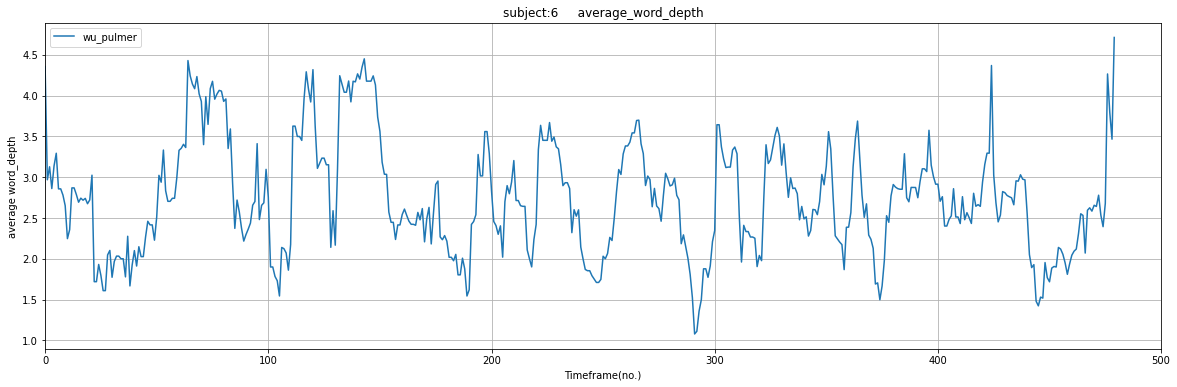

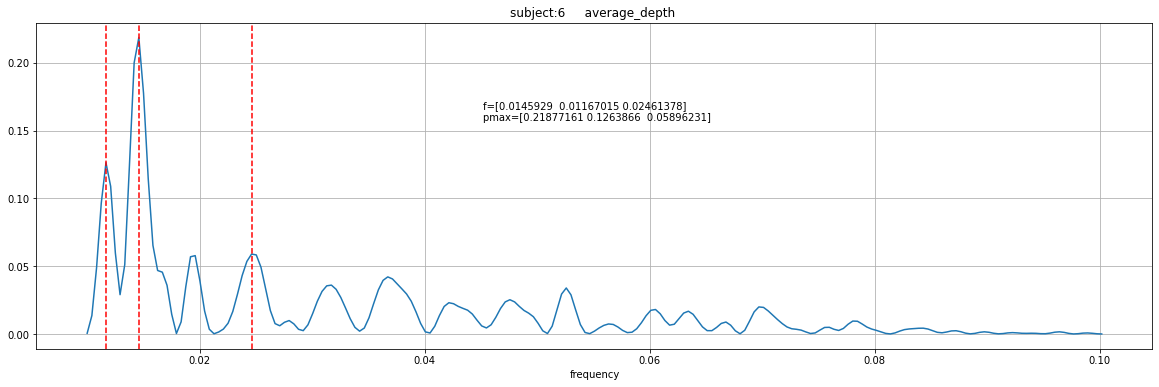

In [42]:

i = 6
calculate(f"data/Text/00{i}(done).csv")
draw(f"data/Text/00{i}(done).csv",i)
#results_csv = pd.DataFrame(list(zip(SBERT,all_sentences_wu_sum,all_sentences_wu_sum_divided,pair_counts)), columns = ['SBERT',"Wu-Pulmer","Wu-Pulmer_divided","pair_counts"])
#results_csv.to_csv(f'data/Text/00{i}(results).csv')


In [43]:
for i in range(0,0):
    if i<10:
        try:
            calculate(f"data/Text/00{i}(done).csv")
            results_csv = pd.DataFrame(list(zip(SBERT,all_sentences_wu_sum,all_sentences_wu_sum_divided,pair_counts)), columns = ['SBERT',"Wu-Pulmer","Wu-Pulmer_divided","pair_counts"])
            results_csv.to_csv(f'data/Text/00{i}(results).csv')
        except:
            print("error:", i)
            continue
    else:
        try:
            calculate(f"data/Text/0{i}(done).csv")
            results_csv = pd.DataFrame(list(zip(SBERT,all_sentences_wu_sum,all_sentences_wu_sum_divided,pair_counts)), columns = ['SBERT',"Wu-Pulmer","Wu-Pulmer_divided","pair_counts"])
            results_csv.to_csv(f'data/Text/0{i}(results).csv')
        except:
            print("error:", i)
            continue